In [1]:
# import torch
# from torch import nn

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display as pretty

from collections import Counter
from functools import cmp_to_key
from typing import List
from decimal import Decimal
import heapq
from tqdm import trange

import sympy
import numpy as np
import scipy.io as sio
import pysindy as ps
from derivative import dxdt
import sys; sys.path.insert(0, "../")
from best_subset import ps_features, brute_force, L0BNB, brute_force_all_subsets
from sklearn.model_selection import train_test_split
from okridge.solvel0 import *
from UBIC import *

from scipy.signal import savgol_filter
from sgolay2 import SGolayFilter2

Sklearn's version: 1.6.1


In [2]:
# data = sio.loadmat('../../SGA-PDE/codes/data/KdV.mat')
# u = data.get("uu"); u_clean = u.copy()
# x = np.squeeze(data.get("x"))
# t = np.squeeze(data.get("tt").reshape(1,201))

data = sio.loadmat('../Datasets/KdV_rudy.mat')
u = (data['usol']).real; u_clean = u.copy()
x = data['x'][0]
t = data['t'].flatten()

print("Domain shape:", u.shape)

Domain shape: (512, 201)


In [3]:
dt = t[1]-t[0]
dx = x[1]-x[0]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [4]:
np.random.seed(0)
noise_lv = float(0)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 0.0


In [5]:
denoise = True
if denoise:
    u = SGolayFilter2(window_size=19, poly_order=3)(u)

In [6]:
function_library = ps.PolynomialLibrary(degree=2, include_bias=False)
weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=4,
    spatiotemporal_grid=XT,
    include_bias=False,
    is_uniform=True,
    K=10000
)

# model = ps.SINDy(feature_library=weak_lib, 
#                  optimizer=L0BNB(max_nonzeros=2, lam=1e-4, is_normal=True, normalize_columns=False, threshold=1e-4), 
#                  feature_names=['u'])

# model.fit(np.expand_dims(u, -1), t=dt)
# model.print()

# y_pre = model.feature_library.convert_u_dot_integral(np.expand_dims(u, -1))
# X_pre = model.optimizer.Theta_

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))

weak_lib.get_feature_names()

/Users/pongpisit/pysindy_latest/pysindy/pysindy/feature_library/weak_pde_library.py:175: UserWarning: is_uniform and periodic have been deprecated.in favor of differetiation_method and diff_kwargs.
  warnings.warn(


['x0',
 'x0^2',
 'x0_1',
 'x0_11',
 'x0_111',
 'x0_1111',
 'x0x0_1',
 'x0^2x0_1',
 'x0x0_11',
 'x0^2x0_11',
 'x0x0_111',
 'x0^2x0_111',
 'x0x0_1111',
 'x0^2x0_1111']

In [7]:
bf_solve, best_subsets = brute_force_all_subsets(X_pre, y_pre) # compare solvel0's res to bf_solve
best_subsets

100%|████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:16<00:00,  1.21s/it]


[(2,),
 (4, 6),
 (4, 6, 10),
 (4, 6, 7, 11),
 (2, 4, 6, 7, 11),
 (2, 4, 6, 7, 10, 11),
 (1, 2, 4, 6, 7, 10, 11),
 (2, 3, 4, 5, 6, 7, 10, 11),
 (2, 3, 4, 6, 7, 10, 11, 12, 13),
 (0, 2, 4, 5, 6, 7, 8, 9, 10, 11),
 (0, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

In [8]:
tau = 3 # we fix its value as a constant
scale = np.log(len(y_pre))
# scale = 1
per = 75

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
except IndexError:
    thres = 0.02
min_thres = 0.02
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    bc_seq.append(last_bc)

best_bc = last_bc
alt_bc = bc_seq[-2] if len(bc_seq) > 1 else last_bc-1
cond = abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) or \
        abs((b_bics[last_bc]-b_bics[alt_bc])/(b_bics[alt_bc]*(last_bc-alt_bc)))
if cond < thres: 
    best_bc = alt_bc
    
last_lam, last_ubic, last_bc, best_bc

threshold: 0.18661563001389586
1 <---> 5 0.10113463398019583


(4.026739132683563,
 array([ 417448.19026586,       0.        ,  204455.76715167,
         562920.01406428,  727648.82695861,  628641.61958244,
         628765.44038326,  629952.1584371 ,  643020.03480689,
         660957.0437718 ,  927258.26804337, 1558005.74306764,
        1785668.20951943, 1929426.45401158]),
 1,
 1)

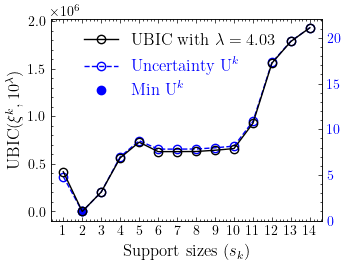

In [9]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
#     ax.annotate('$(u_{xxx}, uu_{x})\checkmark$', fontsize=15, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]-0.25, last_ubic[best_bc]+15000), 
#                  va = "top", ha="left" )
#     ax.annotate('', fontsize=16, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]+0.25, last_ubic[best_bc]+12500), 
#                  arrowprops={'arrowstyle': '->'}, va = "top", ha="left" )
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam,2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12, bbox_to_anchor=(-0.025,0,1,1))
    
    plt.show()

## GA

In [10]:
np.random.seed(0)
# u = u_clean

In [11]:
MAX_ORDER = 4

### GA (Loop of crossover -> mutation -> evaluate_genome) ###
@cmp_to_key
def compare_module(module1, module2):
    if module1 == module2:
        return 0
    lg1 = len(module1); lg2 = len(module2)
    if lg1 != lg2:
        return lg1 - lg2
    if module1 < module2: 
        return -1
    else:
        return 1
    
def generate_module(n_derivatives):
    pde_module = sorted(np.random.randint(0, MAX_ORDER) for i in range(np.random.randint(1, n_derivatives+1)))
    return tuple(pde_module)

def generate_genome(n_modules, n_derivatives):
    genome = fset(generate_module(n_derivatives) for _ in range(n_modules))
    return genome

def generate_chromosome(n_modules, n_derivatives, pop_size):
    chromosome = set()
    count = 0
    while count < pop_size:
        genome = generate_genome(n_modules, n_derivatives)
        if genome not in chromosome:
            chromosome.add(genome)
            count += 1
    return chromosome

def display_derivative(n):
    nx = 'x'*n
    return sympy.symbols(f'u_{nx}')

def display_module(pde_module):
    return np.prod([display_derivative(_) for _ in pde_module])

# coefficients for sorted(encoded_pde)
def display_pde(encoded_pde, coefficients=None):
    if coefficients is None:
        coefficients = [1 for _ in range(len(encoded_pde))]
    out = []
    for module, c in zip(encoded_pde, coefficients):
        out.append(c*display_module(module))
    return sum(out)

# not efficient: O(len(genome))
def crossover(genome1: List, genome2: List, fs=True):
    if genome1 != genome2:
        while True: 
            idx1 = np.random.randint(len(genome1))
            idx2 = np.random.randint(len(genome2))
            if genome1[idx1] != genome2[idx2]:
                break
        genome1[idx1], genome2[idx2] = genome2[idx2], genome1[idx1]
    if fs: 
        genome1, genome2 = fset(genome1), fset(genome2)
    return genome1, genome2

# in-place func
def mutation(genome: List, n_derivatives: int, mutate_rate=(0.4, 0.5, 0.4), fs=True):
    add_rate, delete_rate, order_rate = mutate_rate
    # add
    if np.random.uniform(0, 1) < add_rate:
        genome.append(generate_module(n_derivatives))
    # del
    if np.random.uniform(0, 1) < delete_rate:
        lg = len(genome)
        if lg > 0:
            idx = np.random.randint(lg)
            genome.pop(idx)
    # order
    if np.random.uniform(0, 1) < order_rate:
        lg = len(genome)
        if lg > 0: 
            i = np.random.randint(lg)
            lg = len(genome[i])
            if lg > 0:
                genome[i] = list(genome[i])
                j = np.random.randint(len(genome[i]))
                if genome[i][j] == 0:
                    genome[i][j] = np.random.randint(1, n_derivatives)
                else:
                    genome[i][j] -= 1
                genome[i] = tuple(sorted(genome[i]))
    if fs: 
        genome = fset(genome)
    return genome

def numericalize_module(module, base_features):
    return np.prod([base_features[derivative] for derivative in module], axis=0)

def numericalize_genome(genome, base_features):
    return np.stack([numericalize_module(module, base_features) 
                     for module in genome], axis=-1)

def compute_genome_coefficient(genome, base_features, target):
    features = numericalize_genome(genome, base_features)
    # assert target.shape == features[:, :, 0].shape
    n_features = features.shape[-1]
    target = target.reshape(-1, 1)
    features = features.reshape(-1, n_features)
    coeff, error, _, _ = np.linalg.lstsq(features, target, rcond=None)
    return coeff, error[0]

# Computing coefficients + fitness
def evaluate_genome(genome, base_features, target, epsilon=0):
    coeff, mse = compute_genome_coefficient(genome, base_features, target)
    mse = mse / np.prod(target.shape)
    # fitness = mse + abs(epsilon)*sum(sum(g) for g in genome)
    fitness = mse + abs(epsilon)*len(genome)
    return fitness, coeff

### Miscellaneous for GA ###
def sci_format(n):
    sf = '%.2E' % Decimal(n)
    sf = sf.split('E')
    return float(sf[0]), int(sf[1])

def fset(ls): return frozenset(ls)

In [12]:
from derivative import dxdt

if noise_lv > 0:
    diff = lambda x, y: dxdt(x, y, axis=0, 
                             kind="kalman", alpha=1e-1)
else:
    diff = lambda x, y: dxdt(x, y, axis=0, 
                             kind="finite_difference", k=1)

In [13]:
n_derivatives = 3
n_modules = 3
pop_size = 400
epsilons = [10**(i-6) for i in range(1, 6)] # 1e-5 to 1e-1
differentiation_method = ps.FiniteDifference(is_uniform=True) # good for noiseless
# differentiation_method = ps.SINDyDerivative(kind="kalman", alpha=1e-1, save_smooth=True)

In [14]:
base_features = np.load(f"nn_base_features{int(noise_lv)}.npy")
u_t = base_features[:, 0:1].reshape(len(x), len(t))
base_features = base_features[:, 1:].T
base_features = base_features.reshape(len(base_features), 
                                      len(x), len(t))

In [15]:
# # u_t = differentiation_method._differentiate(u.T, t).T
# u_t = diff(u.T, t).T
# base_features = [u]
# for _ in range(1, MAX_ORDER):
#     # base_features.append(differentiation_method._differentiate(base_features[-1], x))
#     base_features.append(diff(base_features[-1], x))
# base_features = np.array(base_features)

In [16]:
genome = generate_genome(n_modules, n_derivatives); print(genome)
print(evaluate_genome(genome, base_features, u_t))
display_pde(genome, [3,4,5])

frozenset({(1, 3), (0, 3), (3,)})
(0.001108310190006275, array([[0.03872445],
       [1.0333997 ],
       [0.32735595]], dtype=float32))


4*u_*u_xxx + 3*u_x*u_xxx + 5*u_xxx

In [17]:
evaluate_genome(fset({(0,1), (3,)}), base_features, u_t)

(9.588540452926314e-06,
 array([[-5.9448295],
        [-0.9844858]], dtype=float32))

## GA (Following the papers) ##

In [18]:
class LargestUniqueHeap:
    def __init__(self, N, decending=True):
        self.N = N
        self.heap = []
        self.unique_values = set()
        self.decending = decending
        
    def add(self, value):
        if value in self.unique_values:
            # Ignore if the value is already in the set (duplicate)
            return
        
        if len(self.heap) < self.N:
            # If the heap has fewer than N elements, add the new value
            heapq.heappush(self.heap, value)
            self.unique_values.add(value)
        elif value > self.heap[0]:
            # If the new value is greater than the smallest in the heap
            smallest = heapq.heappushpop(self.heap, value)
            # Replace the smallest in the set with the new value
            self.unique_values.remove(smallest)
            self.unique_values.add(value)

    def get_largest_values(self):
        # Return the N largest values in ascending order
        return sorted(self.heap, reverse=self.decending)

n_generations = 25
mutate_rate = (0.4, 0.4, 0.4)
min_len_chrom = 5

print("Initialization...")
chrom = generate_chromosome(n_modules, n_derivatives, pop_size)
set_chrom = chrom.copy()
chrom = list(chrom)

fitnesses = [evaluate_genome(genome, base_features, u_t, epsilon=0)[0] for genome in chrom]
epi = 10**(sci_format(np.median(fitnesses))[1])
print('epi =', epi)
best_chrom_fitnesses = LargestUniqueHeap(pop_size)
for i in range(len(fitnesses)):
    fitnesses[i] += epi*len(chrom[i])
    best_chrom_fitnesses.add((-fitnesses[i], chrom[i]))

print("Learning PDEs...")
for g in trange(n_generations):
    children = []
    # crossover
    for _ in range(2):
        chrom_f, chrom_m = train_test_split(chrom, test_size=0.5, train_size=0.5, shuffle=True)
        for genome_f, genome_m in zip(chrom_f, chrom_m):
            child1, child2 = crossover(list(genome_f), list(genome_m))
            children.append(child1)
            children.append(child2)
    # mutation
    for i in range(len(children)):
        child = list(children[i].copy())
        child = mutation(child, n_derivatives, mutate_rate)
        if len(child) > 0:
            children[i] = fset(child)
    # fitness
    children = set(children)
    chrom = []
    for child in children:
        fitness, _ = evaluate_genome(child, base_features, u_t, epsilon=epi)
        chrom.append((fitness, child))
        best_chrom_fitnesses.add((-fitness, child))
    # Creating parent for the next generation
    chrom = sorted(chrom)
    chrom = [genome for _, genome in chrom][:pop_size]
    
best_chrom_fitnesses = [(v, -k) for k, v in best_chrom_fitnesses.get_largest_values()]
best_chrom_fitnesses[:10]

Initialization...
epi = 0.001
Learning PDEs...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:31<00:00,  3.66s/it]


[(frozenset({(1,)}), 0.0010840083821051156),
 (frozenset({(0, 1)}), 0.0013308567464055115),
 (frozenset({(1, 1, 1)}), 0.0013720385147564446),
 (frozenset({(0, 0, 1)}), 0.0017551024802288607),
 (frozenset({(1, 1, 3)}), 0.0019348949241400951),
 (frozenset({(0, 1), (3,)}), 0.0020095885404529264),
 (frozenset({(1,), (1, 1, 1)}), 0.002049619606478297),
 (frozenset({(0, 1), (1,)}), 0.002069192633848285),
 (frozenset({(1,), (1, 1, 3)}), 0.002069486171896778),
 (frozenset({(0, 0, 1), (1,)}), 0.002071377539775561)]

## GA (V2 implemented by Pongpisit Thanasutives) ##

In [19]:
# n_generations = 200
# mutate_rate = (0.4, 0.4, 0.4)
# min_len_chrom = 5

# print("Initialization...")
# chrom = generate_chromosome(n_modules, n_derivatives, pop_size)
# set_chrom = chrom.copy()
# chrom = list(chrom)

# fitnesses = [evaluate_genome(genome, base_features, u_t, epsilon=0)[0] for genome in chrom]
# epi = 0; epi = 10**(sci_format(np.median(fitnesses))[1]-1+epi)
# # epi = 1e-5 # 1e-4
# print('epi =', epi)
# for i in range(len(fitnesses)):
#     fitnesses[i] += epi*len(chrom[i])
    
# best_chrom_fitnesses = heapq.nsmallest(len(chrom), zip(chrom, fitnesses), 
#                                        key=lambda _: _[1])

# print("Learning PDEs...")
# for _ in trange(n_generations):
#     chrom_f, chrom_m = train_test_split(chrom, test_size=0.5, train_size=0.5, shuffle=True)
#     for genome_f, genome_m in zip(chrom_f, chrom_m):
#         genome_child1, genome_child2 = crossover(list(genome_f), list(genome_m))
#         chrom.append(genome_child1)
#         chrom.append(genome_child2)
#         if genome_child1 not in set_chrom:
#             fitness_child1, _ = evaluate_genome(genome_child1, base_features, u_t, epsilon=epi)
#             best_chrom_fitnesses.append((genome_child1, fitness_child1))
#             set_chrom.add(genome_child1)
#         if genome_child2 not in set_chrom:
#             fitness_child2, _ = evaluate_genome(genome_child2, base_features, u_t, epsilon=epi)
#             best_chrom_fitnesses.append((genome_child2, fitness_child2))
#             set_chrom.add(genome_child2)

#     for i in range(len(chrom)):
#         genome = list(chrom[i].copy())
#         genome = mutation(genome, n_derivatives, mutate_rate)
#         if len(genome) > 0:
#             chrom[i] = fset(genome)
    
#     new_chrom = []; fitnesses = []
#     for i in range(len(chrom)):
#         if chrom[i] not in set_chrom:
#             fitness, _ = evaluate_genome(chrom[i], base_features, u_t, epsilon=epi)
#             best_chrom_fitnesses.append((chrom[i], fitness))
#             new_chrom.append(chrom[i])
#             fitnesses.append(fitness)
#             set_chrom.add(chrom[i])
            
#     best_chrom_fitnesses = heapq.nsmallest(pop_size, best_chrom_fitnesses, key=lambda _ : _[1])
#     chrom_fitnesses = heapq.nsmallest(pop_size, zip(new_chrom, fitnesses), key=lambda _ : _[1])
#     chrom = []; fitnesses = []; del new_chrom
#     for genome, fitness in chrom_fitnesses:
#         chrom.append(genome); fitnesses.append(fitness)
#     if len(chrom) <= min_len_chrom:
#         break

# assert len(chrom) == len(set(chrom))
# # [(frozenset({(0, 1), (2,)}), 0.00020050332746595256),
# #  (frozenset({(0, 1), (1, 1, 2), (2,)}), 0.00030041491578636356),
# #  (frozenset({(0, 1), (1, 2), (2,)}), 0.00030041518841411233),
# #  (frozenset({(0, 1), (0, 1, 2), (2,)}), 0.0003004376828294478),
# #  (frozenset({(0, 0, 1), (0, 1), (2,)}), 0.0003004803064302649),
# #  (frozenset({(0, 0, 0), (0, 1), (2,)}), 0.0003004808326250074),
# #  (frozenset({(0, 0), (0, 1), (2,)}), 0.0003004869577000254),
# #  (frozenset({(0, 1), (1,), (2,)}), 0.0003004883027313859),
# #  (frozenset({(0, 1), (2,), (2, 2, 2)}), 0.0003004915325845),
# #  (frozenset({(0, 1), (1, 1, 1), (2,)}), 0.0003004934561692255)]
# best_chrom_fitnesses[:10]

In [20]:
for potential_pde, _ in best_chrom_fitnesses[:20]:
    potential_pde = sorted(list(potential_pde), key=compare_module)
    pde_coefficient = compute_genome_coefficient(potential_pde, base_features, u_t)[0].flatten()
    pde_coefficient = [round(c, 5) for c in pde_coefficient]
    pretty(display_pde(potential_pde, pde_coefficient))

-0.924019992351532*u_x

-3.00006008148193*u_*u_x

-33.249439239502*u_x**3

-7.2367000579834*u_**2*u_x

27.9092502593994*u_x**2*u_xxx

-5.9448299407959*u_*u_x - 0.984489977359772*u_xxx

-9.05488014221191*u_x**3 - 0.719089984893799*u_x

-0.622319996356964*u_*u_x - 0.759679973125458*u_x

4.19810009002686*u_x**2*u_xxx - 0.844030022621155*u_x

-1.06210005283356*u_**2*u_x - 0.834410011768341*u_x

-2.82726001739502*u_x*u_xxx**2 - 0.860840022563934*u_x

-0.877020001411438*u_x + 1.66737997531891*u_xxx**3

0.447690010070801*u_**2*u_xxx - 0.880620002746582*u_x

0.194830000400543*u_*u_xxx - 0.8748499751091*u_x

-4.79291009902954*u_x*u_xx**2 - 0.89358001947403*u_x

-0.890590012073517*u_x + 0.050670001655817*u_xxx

-0.656809985637665*u_*u_xx*u_xxx - 0.911140024662018*u_x

-0.912180006504059*u_x + 1.63601005077362*u_xx**2*u_xxx

-0.911450028419495*u_x - 0.283630013465881*u_xx*u_xxx

0.551590025424957*u_*u_x*u_xx - 0.919860005378723*u_x

In [21]:
common_modules = []
for genome, _ in best_chrom_fitnesses:
    common_modules.extend([*genome])
common_modules = Counter(common_modules)
print(list(common_modules.values()))

n_common = 0
cum_v = 0; total_v = sum(common_modules.values())
for _, v in common_modules.most_common():
    cum_v += v; n_common += 1
    print(n_common, cum_v/total_v, end=',')
n_common = 15
print(n_common)

common_modules = Counter(common_modules).most_common(n_common)
common_modules = fset(genome for genome, _ in common_modules)
common_modules = sorted(list(common_modules), key=(compare_module))
X_pre = numericalize_genome(common_modules, base_features).reshape(-1, n_common)
y_pre = u_t.reshape(-1, 1)
feature_names = [sympy.latex(display_module(module)).strip().replace(' ', '') 
                 for module in common_modules]
feature_names

[193, 107, 68, 68, 68, 47, 42, 16, 23, 28, 17, 20, 13, 24, 28, 11, 11, 10, 11, 11, 11, 9, 11, 11, 11, 10, 11, 11, 10, 11, 11, 11, 11, 37]
1 0.19455645161290322,2 0.3024193548387097,3 0.3709677419354839,4 0.43951612903225806,5 0.5080645161290323,6 0.5554435483870968,7 0.5977822580645161,8 0.6350806451612904,9 0.6633064516129032,10 0.6915322580645161,11 0.7157258064516129,12 0.7389112903225806,13 0.7590725806451613,14 0.7762096774193549,15 0.7923387096774194,16 0.8054435483870968,17 0.8165322580645161,18 0.8276209677419355,19 0.8387096774193549,20 0.8497983870967742,21 0.8608870967741935,22 0.8719758064516129,23 0.8830645161290323,24 0.8941532258064516,25 0.905241935483871,26 0.9163306451612904,27 0.9274193548387096,28 0.938508064516129,29 0.9495967741935484,30 0.9606854838709677,31 0.9707661290322581,32 0.9808467741935484,33 0.9909274193548387,34 1.0,15


['u_{x}',
 'u_{xxx}',
 'u_{}u_{x}',
 'u_{}u_{xxx}',
 'u_{x}u_{xx}',
 'u_{xx}u_{xxx}',
 'u_{}^{2}u_{x}',
 'u_{}^{2}u_{xxx}',
 'u_{}u_{x}u_{xx}',
 'u_{}u_{xx}u_{xxx}',
 'u_{x}^{3}',
 'u_{x}^{2}u_{xxx}',
 'u_{x}u_{xx}^{2}',
 'u_{x}u_{xxx}^{2}',
 'u_{xxx}^{3}']

In [22]:
from skscope_tools import best_subset_solution, abess_solution, best_subset_all_solutions, abess_all_solutions

In [23]:
coefficients, best_subsets = best_subset_all_solutions(X_pre, y_pre, 8, refine=True)
best_subsets

[[0],
 [1, 2],
 [1, 2, 4],
 [0, 1, 3, 4],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4, 7],
 [0, 2, 3, 4, 5, 6, 7],
 [0, 2, 3, 4, 5, 6, 7, 8]]

In [24]:
brute_force(X_pre, y_pre, 2)

array([[ 0.        ],
       [-0.98448581],
       [-5.94482946],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [25]:
# coefficients, best_subsets = okridge_solvel0_full(X_pre, y_pre, k=8)
# best_subsets

In [26]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75 # 80

# bics = [sm.OLS(y_pre, X_pre[:, bs]).fit().bic for bs in best_subsets]
# aics = [sm.OLS(y_pre, X_pre[:, bs]).fit().aic for bs in best_subsets]
post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
print(b_bics)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
except IndexError:
    thres = 0.02
min_thres = 0.02
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    bc_seq.append(last_bc)

best_bc = last_bc
alt_bc = bc_seq[-2] if len(bc_seq) > 1 else last_bc-1
cond = abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) or \
        abs((b_bics[last_bc]-b_bics[alt_bc])/(b_bics[alt_bc]*(last_bc-alt_bc)))
if cond < thres: 
    best_bc = alt_bc
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[-673724.1945186801, -897067.4900958976, -920737.3606502272, -938951.9111388469, -978138.3309395527, -980005.7089101998, -993315.6910863357, -993860.4260756633]
threshold: 0.034060022042547364
max_lam: 4.890557987968822
1 <---> 1 inf
1 <---> 6 0.021458407991164424


(3.26037199,
 array([-634471.38873383, -876047.17982998, -858802.92078224,
        -874542.26240305, -735774.3248011 , -634485.64552688,
        -843139.28882815, -594632.29625631]),
 1,
 1)

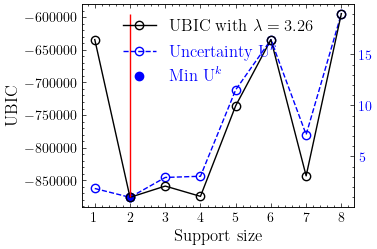

In [27]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}$", fontsize=12)
    ax.set_xlabel("Support size", fontsize=12)
#     ax.annotate('$(u_{xx}, uu_{x})\checkmark$', fontsize=16, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+200000), 
#                  arrowprops={'arrowstyle': '->'})
    ax.vlines(best_bc+1, min(last_ubic), max(last_ubic), color='red')
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {round(abs(last_lam), 2)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12)
    
    plt.show()

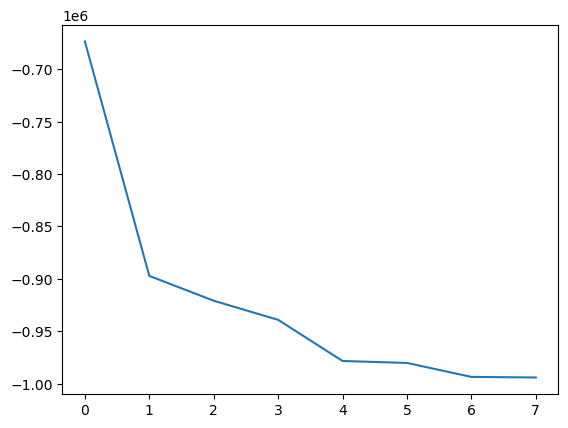

In [28]:
plt.plot(b_bics); plt.show()